In [93]:
#Importing the necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from scipy.linalg import eigh

In [94]:
#Using iris dataset

iris = pd.read_csv(r"C:\Users\Oluwaferanmi\Downloads\iris.csv")

print(f"The number of duplicates is {iris.duplicated().value_counts()}")

The number of duplicates is False    147
True       3
dtype: int64


In [95]:
#Dropping duplicates
iris = iris.drop_duplicates()

In [96]:
def mapp(X):  #returns the class labels as distinct numbers
    if X == "setosa":
        return 0
    if X == "versicolor":
        return 1
    if X == "virginica":
        return 2
    
number = iris.species.map(mapp)
iris["species"] = number

In [97]:
def standardize(X, means = None, stds = None):  #Stanndardizing the dataset
    if means is None and stds is None:
        means = np.mean(X, axis = 0).values
        stds = np.std(X, axis = 0).values
        
    X = (X - means)/stds
        
    return X, means, stds

In [98]:
def train_test_split(X, y, test_size):
    """
    if X is not two dimensional:
        returns: a new dataset
        with two dimensions
        using PCA
        
    elif X is two dimensions:
        returns as it is
        
    else
        returns X is not 2 dim
    
    
    """
    
    from sklearn.preprocessing import StandardScaler
    scale = StandardScaler()
    
    if (X.shape[1] > 2):
        stand_x = scale.fit_transform(X)
        covar_matrix = np.matmul(stand_x.T, stand_x)
        
        eigh_values, eigh_vectors = eigh(covar_matrix, eigvals = (X.shape[1] - 2, X.shape[1] - 1))
        
        X = np.matmul(X, eigh_vectors)
        
    elif (X.shape[1] == 2):
        X = X
    
    else:
        print("X is not 2 dimensional")
        
    indices = list(range(X.shape[0]))
    num_training_instances = int((1 - test_size) * X.shape[0])
    np.random.shuffle(indices)
    train_indices = indices[:num_training_instances]
    test_indices = indices[num_training_instances:]

    # split the actual data into train and test
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
    

    X_train, _means, _stds = standardize(X_train)
    X_test, _, _ = standardize(X_test, _means, _stds)
    
    
    print(f'X_train: {X_train.shape}')
    print(f'X_test: {X_test.shape}')
    print(f'y_train: {y_train.shape}')
    print(f'y_test: {y_test.shape}')
    
    return X_train, X_test, y_train, y_test

In [99]:
def train_test_set(X_train, X_test, y_train, y_test):
    """
    returns: train set which contains
             the standardizing the
             standardized X_train and
             y_train
             
             test set which contains
             the standardizing the
             standardized X_test and
             y_test
    
    
    """
    
    X_train = X_train.values
    X_test = X_test.values

    train_set = np.vstack((X_train.T, y_train.T)).T
    test_set = np.vstack((X_test.T, y_test.T)).T
    
    print(f'The shape of the train set is {train_set.shape}')
    print(f'The shape of the test set is {test_set.shape}')
    
    return train_set, test_set

In [100]:
#This function returns the Optimal_k using cross validation
def k_Optimal(X_tr, y_tr):
    Score = []
    for i in range(1,40):
        model = KNeighborsClassifier(n_neighbors = i)
        scores = cross_val_score(model, X_tr, y_tr, cv = 10)
        Score.append(np.mean(scores))
    
    Error = [1 - x for x in Score]
    Optimal_k = range(1,40)[Error.index(min(Error))]
    
    return int(Optimal_k)

In [101]:
from math import sqrt
def euclidean_distance(x, y):
    """
    This function calculates
    the euclidean distance between
    points X and y
    
    """
    distance = 0
    for i in range(len(x)):
        distance += (x[i] - y[i])**2
    
    return sqrt(distance)

In [102]:
# Returns the nearest neighbors

def Nearest_neighbors(train, test, n_neighbors):
#     for i in range(len(test)):
    distance = []
    for j in range(len(train)):
        dist = euclidean_distance(test, train[j,0:-1])
        distance.append((train[j], dist))
    distance.sort(key=lambda tup: tup[1])

    neighbors = []
    for i in range(n_neighbors):
        neighbors.append(distance[i][0])
        
    return neighbors

In [103]:
def majority_vote(neighbors):
    """
    This function does a majority vote
    on the class labels of the neighbors
    
    returns: Class with the highest vote
    
    """
    Class_labels = [row[-1] for row in neighbors]
    pred_class = max(Class_labels, key = Class_labels.count)
    return pred_class

In [104]:
def KNClassifier(train_set, test_set, k):
    neighbors = Nearest_neighbors(train_set, test_set, k)
    Class_labels = majority_vote(neighbors)
    return Class_labels

In [105]:
def DecisionBoundary1(data):
    plt.rcParams['figure.figsize'] = [14,7]
    plt.rcParams['figure.autolayout'] = True
    h = 0.2 #Interval for mesh
    
    X = data.iloc[:, 0:-1]
    y = data.iloc[:, -1]
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 0.2)
   
    
    Optimal_k = k_Optimal(X_train, y_train)
    print(f'Optimal value of k is {Optimal_k}')
    
    cmaplight = ListedColormap(['orange', 'blue', 'cyan'])
    cmapbold = ListedColormap(['darkorange', 'darkblue', 'c'])
    
    f1_min, f1_max = X_train.iloc[:,0].min(), X_train.iloc[:,0].max()
    f2_min, f2_max = X_train.iloc[:,1].min(), X_train.iloc[:,1].max()
    
    
    for weight in ["uniform", "distance"]: #Uisng uniform and distance as measure in the model
        model = KNeighborsClassifier(n_neighbors = Optimal_k, weights = weight)

        f1, f2 = np.meshgrid(np.arange(f1_min, f1_max, h), np.arange(f2_min, f2_max, h))
        model.fit(X_train, y_train)
        z = model.predict(np.c_[f1.ravel(), f2.ravel()])
        z = z.reshape(f1.shape)

        plt.figure()
        plt.contourf(f1, f2, z, cmap = cmapbold)

        sns.scatterplot(X_train.iloc[:, 0], X_train.iloc[:, 1], hue = y_train,
                       cmap = cmaplight)
        plt.xlim([f1_min, f1_max])
        plt.ylim([f2_min, f2_max])

        
        if (X.shape[1] == 2):
            plt.xlabel(data.columns[0])
            plt.ylabel(data.columns[1])
        
        else:
            plt.xlabel("First Principal using PCA")
            plt.ylabel("Second Principal using PCA")
        plt.title(f'Using {weight}')
        plt.show()

X_train: (117, 2)
X_test: (30, 2)
y_train: (117,)
y_test: (30,)
Optimal value of k is 8


C:\Users\Oluwaferanmi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


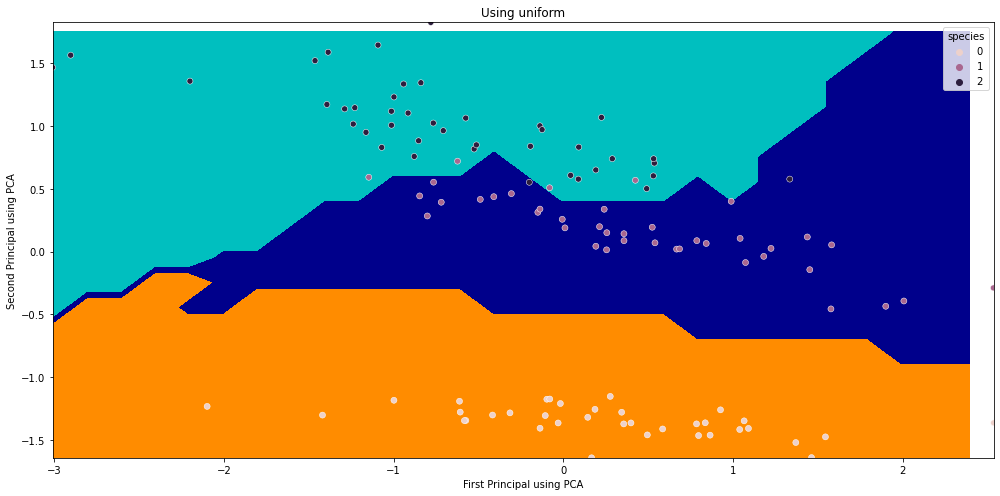

C:\Users\Oluwaferanmi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


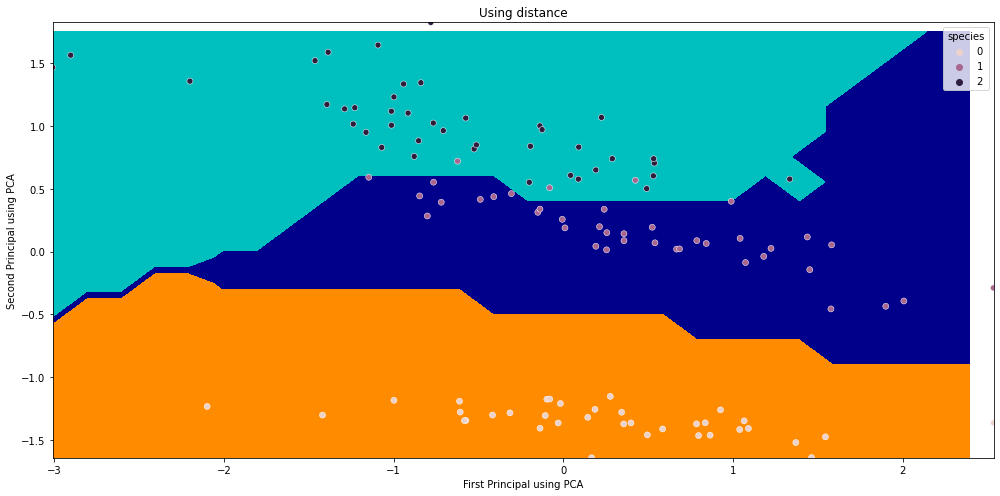

In [106]:
DecisionBoundary1(iris)

In [107]:
def DecisionBoundary2(data):
    """
  This function uses a 
  built-from-scratch KNN algorithm
  
  """
    plt.rcParams['figure.figsize'] = [14,7]
    plt.rcParams['figure.autolayout'] = True
    h = 0.2
    X = data.iloc[:, 0:-1]
    y = data.iloc[:, -1]
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 0.2)
    train_set, test_set = train_test_set(X_train, X_test, y_train, y_test)
   
    
    Optimal_k = k_Optimal(X_train, y_train)
    print(f'Optimal value of k is {Optimal_k}')
    
    
    cmaplight = ListedColormap(['orange', 'blue', 'cyan'])
    cmapbold = ListedColormap(['darkorange', 'darkblue', 'c'])
    f1_min, f1_max = X_train.iloc[:,0].min(), X_train.iloc[:,0].max()
    f2_min, f2_max = X_train.iloc[:,1].min(), X_train.iloc[:,1].max()
    
    
    

    f1, f2 = np.meshgrid(np.arange(f1_min, f1_max, h), np.arange(f2_min, f2_max, h))

    Z = []
    for i in range(len(np.c_[f1.ravel(), f2.ravel()])):
        Z.append(KNClassifier(train_set, np.c_[f1.ravel(), f2.ravel()][i, 0:-1] , Optimal_k))
    
    Z = np.array(Z).reshape(f1.shape)
#     np.array(Z).reshape(1,-1)

    plt.figure()
    plt.contourf(f1, f2, Z, cmap = cmapbold)

    sns.scatterplot(X_train.iloc[:, 0], X_train.iloc[:, 1], hue = y_train,
                   cmap = cmaplight)
    plt.xlim([f1_min, f1_max])
    plt.ylim([f2_min, f2_max])


    if (X.shape[1] == 2):
        plt.xlabel(data.columns[0])
        plt.ylabel(data.columns[1])

    else:
        plt.xlabel("First Principal using PCA")
        plt.ylabel("Second Principal using PCA")
#     plt.title(f'Using {weight}')
    plt.show()

X_train: (117, 2)
X_test: (30, 2)
y_train: (117,)
y_test: (30,)
The shape of the train set is (117, 3)
The shape of the test set is (30, 3)
Optimal value of k is 5


C:\Users\Oluwaferanmi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


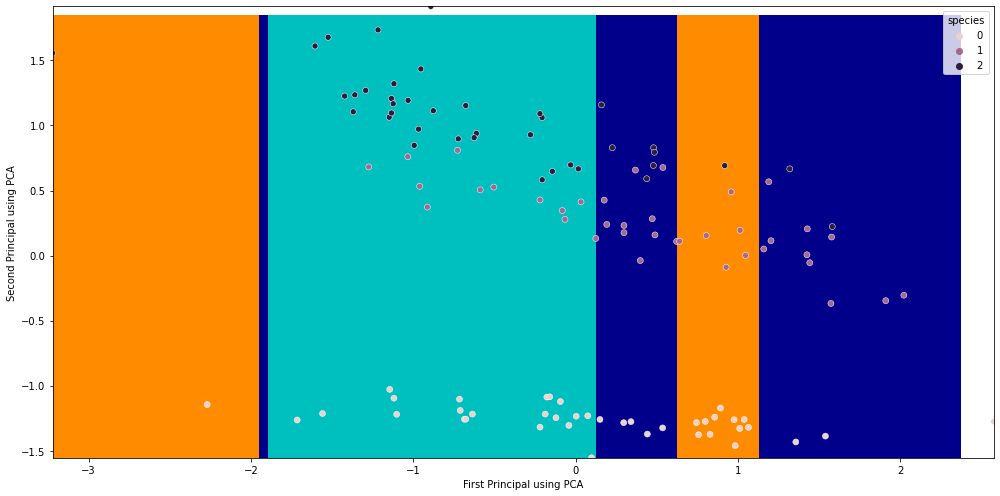

In [108]:
DecisionBoundary2(iris)